Importing all libraries

In [1]:
!pip install --quiet kiteconnect pandas matplotlib numpy
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from kiteconnect import KiteConnect
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive',force_remount = True)
print("All libraries installed and imported successfully")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 509.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.5/771.5 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 1.0 MB/s eta 0:00:00
Mounted at /content/drive
All libraries installed and imported successfully


Setting up API key

In [2]:
API_KEY = "8re7mjcm2btaozwf"
API_SECRET = "fw8gm7wfeclcic9rlkp0tbzx4h2ss2n1"
REDIRECT_URL = "https://example.com"


kite = KiteConnect(api_key=API_KEY)


login_url = kite.login_url()
print(f"Login to your Kite account using this URL: {login_url}")


request_token = input("Paste the request token from the URL here: ")


try:
    data = kite.generate_session(request_token=request_token, api_secret=API_SECRET)
    access_token = data["access_token"]
    print(f"Access Token: {access_token}")


    kite.set_access_token(access_token)
    print("Kite Connect is now initialized and ready to use!")
except Exception as e:
    print(f"Error generating access token: {e}")

Login to your Kite account using this URL: https://kite.zerodha.com/connect/login?api_key=8re7mjcm2btaozwf&v=3
Paste the request token from the URL here: Ec9MIAtNQskoBeF9Afo69fqKPPVl4FNl
Access Token: k3Nxh5bTkvqorL7t24p2J49BFEREx6N6
Kite Connect is now initialized and ready to use!


Fetching Nifty 50 instrument token

In [3]:
import os
import pandas as pd
from datetime import datetime, timedelta

def get_instrument_token(kite, tradingsymbol="NIFTY", exchange="NSE"):
    try:
        # Fetch all instruments for the given exchange
        instruments = kite.instruments(exchange)

        # Loop through the instruments and find the matching trading symbol
        for instrument in instruments:
            if instrument['tradingsymbol'] == tradingsymbol:
                print(f"Instrument Token for {tradingsymbol}: {instrument['instrument_token']}")
                return instrument['instrument_token']

        print(f"Instrument Token for {tradingsymbol} not found.")
        return None
    except Exception as e:
        print(f"Error fetching instrument token: {e}")
        return None

# Example Usage
nifty50_token = get_instrument_token(kite, tradingsymbol="NIFTY 50", exchange="NSE")

Instrument Token for NIFTY 50: 256265


Fetching 1min timeframe data for 2024

In [4]:
import os
import pandas as pd
from datetime import datetime, timedelta

def fetch_1min_data_2024(kite, instrument_token, drive_output_dir):
    """
    Fetch 1-minute OHLC data for 2024 and save it as a CSV file on Google Drive.

    Args:
        kite: An instance of the KiteConnect API.
        instrument_token: The instrument token for which to fetch data.
        drive_output_dir: Path to the Google Drive directory to save the file.

    Returns:
        str: Path to the saved CSV file.
    """
    # Define the start and end date for 2024
    start_date = datetime(2024, 1, 1)
    end_date = datetime(2024, 12, 31)

    # Split the date range into chunks of 30 days (Kite API limitation)
    date_ranges = []
    current_start = start_date
    while current_start < end_date:
        current_end = min(current_start + timedelta(days=30), end_date)
        date_ranges.append((current_start, current_end))
        current_start = current_end + timedelta(days=1)

    # Initialize an empty DataFrame to store all data
    all_data = pd.DataFrame()

    # Fetch data for each date range
    for start, end in date_ranges:
        print(f"Fetching data from {start.date()} to {end.date()}...")
        try:
            # Fetch historical data from Kite API
            data = kite.historical_data(
                instrument_token=instrument_token,
                from_date=start.strftime("%Y-%m-%d"),
                to_date=end.strftime("%Y-%m-%d"),
                interval="minute"
            )

            # Convert to DataFrame
            df = pd.DataFrame(data)

            # Keep only OHLC columns
            if not df.empty:
                df = df[['date', 'open', 'high', 'low', 'close']]
                df['date'] = pd.to_datetime(df['date'])
                df.set_index('date', inplace=True)

                # Append to the main DataFrame
                all_data = pd.concat([all_data, df])
        except Exception as e:
            print(f"Error fetching data from {start.date()} to {end.date()}: {e}")

    # Save the data to a CSV file in the Google Drive directory
    if not all_data.empty:
        file_path = os.path.join(drive_output_dir, "new_1min_data_2024.csv")
        all_data.to_csv(file_path)
        print(f"Data successfully saved to {file_path}")
        return file_path
    else:
        print("No data fetched.")
        return None

# Define instrument token for the desired stock/index
instrument_token = 256265  # Replace with your desired instrument token

# Define Google Drive directory to save the file
drive_output_dir = "/content/drive/My Drive"

# Fetch and save 2024 data
fetch_1min_data_2024(kite, instrument_token, drive_output_dir)

Fetching data from 2024-01-01 to 2024-01-31...
Fetching data from 2024-02-01 to 2024-03-02...
Fetching data from 2024-03-03 to 2024-04-02...
Fetching data from 2024-04-03 to 2024-05-03...
Fetching data from 2024-05-04 to 2024-06-03...
Fetching data from 2024-06-04 to 2024-07-04...
Fetching data from 2024-07-05 to 2024-08-04...
Fetching data from 2024-08-05 to 2024-09-04...
Fetching data from 2024-09-05 to 2024-10-05...
Fetching data from 2024-10-06 to 2024-11-05...
Fetching data from 2024-11-06 to 2024-12-06...
Fetching data from 2024-12-07 to 2024-12-31...
Data successfully saved to /content/drive/My Drive/new_1min_data_2024.csv


'/content/drive/My Drive/new_1min_data_2024.csv'

Fetch 5min timeframe data and store it in a separate csv file

In [5]:
import os
import pandas as pd
from datetime import datetime, timedelta

def fetch_5min_data_2024(kite, instrument_token, drive_output_dir):
    """
    Fetch 5-minute OHLC data for 2024 and save it as a CSV file on Google Drive.

    Args:
        kite: An instance of the KiteConnect API.
        instrument_token: The instrument token for which to fetch data.
        drive_output_dir: Path to the Google Drive directory to save the file.

    Returns:
        str: Path to the saved CSV file.
    """
    # Initialize an empty DataFrame to store all data
    all_data = pd.DataFrame()

    # Loop through each month in 2024
    for month in range(1, 13):
        start_date = datetime(2024, month, 1)
        next_month = start_date + timedelta(days=32)
        end_date = datetime(next_month.year, next_month.month, 1) - timedelta(days=1)

        print(f"Fetching data from {start_date.date()} to {end_date.date()}...")

        try:
            # Fetch historical data for the current month
            data = kite.historical_data(
                instrument_token=instrument_token,
                from_date=start_date.strftime("%Y-%m-%d"),
                to_date=end_date.strftime("%Y-%m-%d"),
                interval="5minute"  # Changed to 5-minute timeframe
            )

            # Convert to DataFrame
            df = pd.DataFrame(data)

            # Keep only OHLC columns
            if not df.empty:
                df = df[['date', 'open', 'high', 'low', 'close']]
                df['date'] = pd.to_datetime(df['date'])
                df.set_index('date', inplace=True)

                # Append to the main DataFrame
                all_data = pd.concat([all_data, df])
        except Exception as e:
            print(f"Error fetching data from {start_date.date()} to {end_date.date()}: {e}")

    # Save the data to a CSV file in the Google Drive directory
    if not all_data.empty:
        file_path = os.path.join(drive_output_dir, "5min_data_2024.csv")  # Changed filename
        all_data.to_csv(file_path)
        print(f"5-minute data successfully saved to {file_path}")
        return file_path
    else:
        print("No data fetched.")
        return None

# Define instrument token for the desired stock/index
instrument_token = 256265  # Replace with your desired instrument token

# Define Google Drive directory to save the file
drive_output_dir = "/content/drive/My Drive"

# Fetch and save 5-minute timeframe data for 2024
fetch_5min_data_2024(kite, instrument_token, drive_output_dir)


Fetching data from 2024-01-01 to 2024-01-31...
Fetching data from 2024-02-01 to 2024-02-29...
Fetching data from 2024-03-01 to 2024-03-31...
Fetching data from 2024-04-01 to 2024-04-30...
Fetching data from 2024-05-01 to 2024-05-31...
Fetching data from 2024-06-01 to 2024-06-30...
Fetching data from 2024-07-01 to 2024-07-31...
Fetching data from 2024-08-01 to 2024-08-31...
Fetching data from 2024-09-01 to 2024-09-30...
Fetching data from 2024-10-01 to 2024-10-31...
Fetching data from 2024-11-01 to 2024-11-30...
Fetching data from 2024-12-01 to 2024-12-31...
5-minute data successfully saved to /content/drive/My Drive/5min_data_2024.csv


'/content/drive/My Drive/5min_data_2024.csv'

Calculate the HL/2 (high-low midpoint)


In [6]:
import pandas as pd

def add_hl2_to_csv(file_path):
    """
    Calculate HL2 (High-Low Midpoint) and add it as a column to the CSV file.

    Args:
        file_path (str): Path to the 5-minute CSV file.

    Returns:
        str: Path to the updated CSV file.
    """
    try:
        # Load the CSV file
        df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')

        # Calculate HL2
        df['hl2'] = (df['high'] + df['low']) / 2

        # Save the updated DataFrame back to the CSV file
        df.to_csv(file_path)
        print(f"HL2 column added and saved to {file_path}")
        return file_path
    except Exception as e:
        print(f"Error while adding HL2: {e}")
        return None

# Path to the 5-minute CSV file
file_path = "/content/drive/My Drive/5min_data_2024.csv"  # Updated file name

# Add HL2 to the 5-minute CSV file
add_hl2_to_csv(file_path)


HL2 column added and saved to /content/drive/My Drive/5min_data_2024.csv


'/content/drive/My Drive/5min_data_2024.csv'

Calculate ATR for supertrend channel

In [7]:
import pandas as pd

def add_atr_to_csv_rma(file_path, length=10, multiplier=3):
    """
    Calculate ATR (Average True Range) using RMA (Wilder's Moving Average)
    and add it as a column to the CSV file.

    Args:
        file_path (str): Path to the 5-minute CSV file.
        length (int): Lookback period for ATR calculation (default: 10).
        multiplier (float): Multiplier for ATR (default: 3).

    Returns:
        str: Path to the updated CSV file.
    """
    try:
        # Load the CSV file
        df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')

        # Initialize columns for True Range and ATR
        df['true_range'] = 0.0
        df['atr'] = 0.0

        # Calculate True Range (TR)
        for i in range(1, len(df)):
            high = df.iloc[i]['high']
            low = df.iloc[i]['low']
            prev_close = df.iloc[i - 1]['close']

            tr = max(
                high - low,  # High - Low
                abs(high - prev_close),  # High - Previous Close
                abs(low - prev_close)  # Low - Previous Close
            )
            df.at[df.index[i], 'true_range'] = tr

        # Calculate ATR using RMA
        for i in range(len(df)):
            if i == 0:
                # Set initial ATR as the simple average of the first 'length' TR values
                df.at[df.index[i], 'atr'] = 0.0
            elif i < length:
                # Simple average for the first 'length' rows
                df.at[df.index[i], 'atr'] = df['true_range'][:i+1].mean()
            else:
                # Wilder's RMA formula
                prev_atr = df.iloc[i - 1]['atr']
                tr = df.iloc[i]['true_range']
                df.at[df.index[i], 'atr'] = ((prev_atr * (length - 1)) + tr) / length

        # Apply the multiplier to scale the ATR (if needed)
        df['atr'] *= multiplier

        # Drop the intermediate 'true_range' column (optional)
        df.drop(columns=['true_range'], inplace=True)

        # Save the updated DataFrame back to the CSV file
        df.to_csv(file_path)
        print(f"ATR (RMA-based) column added and saved to {file_path}")
        return file_path
    except Exception as e:
        print(f"Error while adding ATR: {e}")
        return None

# Path to the 5-minute CSV file
file_path = "/content/drive/My Drive/5min_data_2024.csv"  # Updated file name

# Add ATR to the 5-minute CSV file
add_atr_to_csv_rma(file_path, length=10, multiplier=3)


ATR (RMA-based) column added and saved to /content/drive/My Drive/5min_data_2024.csv


'/content/drive/My Drive/5min_data_2024.csv'

Calculate initial upper band

In [8]:
import pandas as pd

def add_initial_upper_band_to_csv(file_path):
    """
    Calculate the Initial Upper Band and add it as a column to the CSV file.

    Args:
        file_path (str): Path to the 5-minute CSV file.

    Returns:
        str: Path to the updated CSV file.
    """
    try:
        # Load the CSV file
        df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')

        # Ensure required columns are present
        if 'hl2' not in df.columns or 'atr' not in df.columns:
            raise ValueError("Required columns 'hl2' or 'atr' not found in the CSV file. Make sure HL2 and ATR are calculated first.")

        # Calculate Initial Upper Band
        df['initial_upper_band'] = df['hl2'] + df['atr']

        # Save the updated DataFrame back to the CSV file
        df.to_csv(file_path)
        print(f"Initial Upper Band column added and saved to {file_path}")
        return file_path
    except Exception as e:
        print(f"Error while adding Initial Upper Band: {e}")
        return None

# Path to the 5-minute CSV file
file_path = "/content/drive/My Drive/5min_data_2024.csv"  # Updated file name

# Add Initial Upper Band to the CSV file
add_initial_upper_band_to_csv(file_path)


Initial Upper Band column added and saved to /content/drive/My Drive/5min_data_2024.csv


'/content/drive/My Drive/5min_data_2024.csv'

Calculate initial lower band

In [9]:
import pandas as pd

def add_initial_lower_band_to_csv(file_path):
    """
    Calculate the Initial Lower Band and add it as a column to the CSV file.

    Args:
        file_path (str): Path to the 5-minute CSV file.

    Returns:
        str: Path to the updated CSV file.
    """
    try:
        # Load the CSV file
        df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')

        # Ensure required columns are present
        if 'hl2' not in df.columns or 'atr' not in df.columns:
            raise ValueError("Required columns 'hl2' or 'atr' not found in the CSV file. Make sure HL2 and ATR are calculated first.")

        # Calculate Initial Lower Band
        df['initial_lower_band'] = df['hl2'] - df['atr']

        # Save the updated DataFrame back to the CSV file
        df.to_csv(file_path)
        print(f"Initial Lower Band column added and saved to {file_path}")
        return file_path
    except Exception as e:
        print(f"Error while adding Initial Lower Band: {e}")
        return None

# Path to the 5-minute CSV file
file_path = "/content/drive/My Drive/5min_data_2024.csv"  # Updated file name

# Add Initial Lower Band to the CSV file
add_initial_lower_band_to_csv(file_path)


Initial Lower Band column added and saved to /content/drive/My Drive/5min_data_2024.csv


'/content/drive/My Drive/5min_data_2024.csv'

Calculate supertrend upper band

In [10]:
import pandas as pd

def add_supertrend_upper_band_to_csv(file_path):
    """
    Calculate the Dynamic Supertrend Upper Band using the previous close
    and add it as a column to the CSV file.

    Args:
        file_path (str): Path to the 5-minute CSV file.

    Returns:
        str: Path to the updated CSV file.
    """
    try:
        # Load the CSV file
        df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')

        # Ensure required columns are present
        if 'initial_upper_band' not in df.columns:
            raise ValueError("Required column 'initial_upper_band' not found in the CSV file. Make sure Initial Upper Band is calculated first.")

        if 'close' not in df.columns:
            raise ValueError("Required column 'close' not found in the CSV file. Ensure that the CSV contains OHLC data.")

        # Initialize the Dynamic Supertrend Upper Band column
        df['supertrend_upper'] = 0.0

        # Calculate the Dynamic Supertrend Upper Band
        for i in range(len(df)):
            if i == 0:
                # For the first row, set the Supertrend Upper Band to the Initial Upper Band
                df.at[df.index[i], 'supertrend_upper'] = df.at[df.index[i], 'initial_upper_band']
            else:
                prev_supertrend_upper = df.at[df.index[i - 1], 'supertrend_upper']
                initial_upper = df.at[df.index[i], 'initial_upper_band']
                prev_close = df.at[df.index[i - 1], 'close']  # Use the previous close price

                # Apply the logic for dynamic adjustment
                if prev_close < prev_supertrend_upper:
                    df.at[df.index[i], 'supertrend_upper'] = min(initial_upper, prev_supertrend_upper)
                else:
                    df.at[df.index[i], 'supertrend_upper'] = initial_upper

        # Save the updated DataFrame back to the CSV file
        df.to_csv(file_path)
        print(f"Dynamic Supertrend Upper Band column added and saved to {file_path}")
        return file_path
    except Exception as e:
        print(f"Error while adding Dynamic Supertrend Upper Band: {e}")
        return None

# Path to the 5-minute CSV file
file_path = "/content/drive/My Drive/5min_data_2024.csv"  # Updated file name

# Add Dynamic Supertrend Upper Band to the CSV file
add_supertrend_upper_band_to_csv(file_path)


Dynamic Supertrend Upper Band column added and saved to /content/drive/My Drive/5min_data_2024.csv


'/content/drive/My Drive/5min_data_2024.csv'

Calculate supertrend lower band

In [11]:
import pandas as pd

def add_supertrend_lower_band_to_csv(file_path):
    """
    Calculate the Dynamic Supertrend Lower Band using the previous close
    and add it as a column to the CSV file.

    Args:
        file_path (str): Path to the 5-minute CSV file.

    Returns:
        str: Path to the updated CSV file.
    """
    try:
        # Load the CSV file
        df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')

        # Ensure required columns are present
        if 'initial_lower_band' not in df.columns:
            raise ValueError("Required column 'initial_lower_band' not found in the CSV file. Make sure Initial Lower Band is calculated first.")

        if 'close' not in df.columns:
            raise ValueError("Required column 'close' not found in the CSV file. Ensure that the CSV contains OHLC data.")

        # Initialize the Dynamic Supertrend Lower Band column
        df['supertrend_lower'] = 0.0

        # Calculate the Dynamic Supertrend Lower Band
        for i in range(len(df)):
            if i == 0:
                # For the first row, set the Supertrend Lower Band to the Initial Lower Band
                df.at[df.index[i], 'supertrend_lower'] = df.at[df.index[i], 'initial_lower_band']
            else:
                prev_supertrend_lower = df.at[df.index[i - 1], 'supertrend_lower']
                initial_lower = df.at[df.index[i], 'initial_lower_band']
                prev_close = df.at[df.index[i - 1], 'close']  # Use the previous close price

                # Apply the logic for dynamic adjustment
                if prev_close >= prev_supertrend_lower:
                    df.at[df.index[i], 'supertrend_lower'] = max(initial_lower, prev_supertrend_lower)
                else:
                    df.at[df.index[i], 'supertrend_lower'] = initial_lower

        # Save the updated DataFrame back to the CSV file
        df.to_csv(file_path)
        print(f"Dynamic Supertrend Lower Band column added and saved to {file_path}")
        return file_path
    except Exception as e:
        print(f"Error while adding Dynamic Supertrend Lower Band: {e}")
        return None

# Path to the 5-minute CSV file
file_path = "/content/drive/My Drive/5min_data_2024.csv"  # Updated file name

# Add Dynamic Supertrend Lower Band to the CSV file
add_supertrend_lower_band_to_csv(file_path)


Dynamic Supertrend Lower Band column added and saved to /content/drive/My Drive/5min_data_2024.csv


'/content/drive/My Drive/5min_data_2024.csv'

Calculate oscillation state

In [12]:
import pandas as pd

def add_os_to_csv(file_path):
    """
    Calculate the Oscillation State (os) using current row data
    and add it as a column to the CSV file.

    Args:
        file_path (str): Path to the 5-minute CSV file.

    Returns:
        str: Path to the updated CSV file.
    """
    try:
        # Load the CSV file
        df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')

        # Ensure required columns are present
        if 'supertrend_upper' not in df.columns or 'supertrend_lower' not in df.columns:
            raise ValueError("Required columns 'supertrend_upper' or 'supertrend_lower' not found in the CSV file. Make sure Dynamic Supertrend Bands are calculated first.")

        if 'close' not in df.columns:
            raise ValueError("Required column 'close' not found in the CSV file. Ensure that the CSV contains OHLC data.")

        # Initialize the Oscillation State column
        df['os'] = 0  # Default to bearish

        # Calculate the Oscillation State
        for i in range(len(df)):
            close = df.at[df.index[i], 'close']
            upper_band = df.at[df.index[i], 'supertrend_upper']
            lower_band = df.at[df.index[i], 'supertrend_lower']

            # Compare the current close with the current bands
            if close > upper_band:
                df.at[df.index[i], 'os'] = 1  # Bullish
            elif close < lower_band:
                df.at[df.index[i], 'os'] = 0  # Bearish
            else:
                if i > 0:
                    # Retain the previous state if close is between the bands
                    df.at[df.index[i], 'os'] = df.at[df.index[i - 1], 'os']
                else:
                    # For the first row, default to bearish if between bands
                    df.at[df.index[i], 'os'] = 0

        # Save the updated DataFrame back to the CSV file
        df.to_csv(file_path)
        print(f"Oscillation State column added and saved to {file_path}")
        return file_path
    except Exception as e:
        print(f"Error while adding Oscillation State: {e}")
        return None

# Path to the 5-minute CSV file
file_path = "/content/drive/My Drive/5min_data_2024.csv"  # Updated file name

# Add Oscillation State to the CSV file
add_os_to_csv(file_path)


Oscillation State column added and saved to /content/drive/My Drive/5min_data_2024.csv


'/content/drive/My Drive/5min_data_2024.csv'

Calculate supertrend pivot

In [13]:
import pandas as pd

def add_supertrend_pivot_to_csv(file_path):
    """
    Calculate the Supertrend Pivot (spt) and add it as a column to the CSV file.

    Args:
        file_path (str): Path to the 5-minute CSV file.

    Returns:
        str: Path to the updated CSV file.
    """
    try:
        # Load the CSV file
        df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')

        # Ensure required columns are present
        if 'os' not in df.columns:
            raise ValueError("Required column 'os' not found in the CSV file. Make sure Oscillation State is calculated first.")

        if 'supertrend_upper' not in df.columns or 'supertrend_lower' not in df.columns:
            raise ValueError("Required columns 'supertrend_upper' or 'supertrend_lower' not found in the CSV file. Make sure Dynamic Supertrend Bands are calculated first.")

        # Initialize the Supertrend Pivot column
        df['spt'] = 0.0

        # Calculate the Supertrend Pivot
        for i in range(len(df)):
            os = df.at[df.index[i], 'os']
            if os == 1:
                # Bullish: Use the Supertrend Lower Band as the pivot
                df.at[df.index[i], 'spt'] = df.at[df.index[i], 'supertrend_lower']
            else:
                # Bearish: Use the Supertrend Upper Band as the pivot
                df.at[df.index[i], 'spt'] = df.at[df.index[i], 'supertrend_upper']

        # Save the updated DataFrame back to the CSV file
        df.to_csv(file_path)
        print(f"Supertrend Pivot column added and saved to {file_path}")
        return file_path
    except Exception as e:
        print(f"Error while adding Supertrend Pivot: {e}")
        return None

# Path to the 5-minute CSV file
file_path = "/content/drive/My Drive/5min_data_2024.csv"  # Updated file name

# Add Supertrend Pivot to the CSV file
add_supertrend_pivot_to_csv(file_path)


Supertrend Pivot column added and saved to /content/drive/My Drive/5min_data_2024.csv


'/content/drive/My Drive/5min_data_2024.csv'

Calculate max channel

In [14]:
import pandas as pd

def add_max_channel_to_csv(file_path):
    """
    Calculate the Max Channel incorporating the Supertrend Pivot (spt)
    and add it as a column to the CSV file.

    Args:
        file_path (str): Path to the 5-minute CSV file.

    Returns:
        str: Path to the updated CSV file.
    """
    try:
        # Load the CSV file
        df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')

        # Ensure required columns are present
        if 'os' not in df.columns or 'close' not in df.columns or 'spt' not in df.columns:
            raise ValueError("Required columns 'os', 'close', or 'spt' not found in the CSV file. Make sure Oscillation State and Supertrend Pivot are calculated first.")

        # Initialize the Max Channel column
        df['max_channel'] = 0.0

        # Calculate the Max Channel
        for i in range(len(df)):
            close = df.at[df.index[i], 'close']
            os = df.at[df.index[i], 'os']
            spt = df.at[df.index[i], 'spt']

            if i == 0:
                # Initialize Max Channel for the first row
                df.at[df.index[i], 'max_channel'] = close
            else:
                prev_max_channel = df.at[df.index[i - 1], 'max_channel']
                prev_os = df.at[df.index[i - 1], 'os']

                if close > spt:  # Price crosses the Supertrend Pivot
                    df.at[df.index[i], 'max_channel'] = max(prev_max_channel, close)
                elif os == 1:  # Bullish trend
                    df.at[df.index[i], 'max_channel'] = max(close, prev_max_channel)
                else:  # Bearish trend
                    df.at[df.index[i], 'max_channel'] = min(spt, prev_max_channel)

        # Save the updated DataFrame back to the CSV file
        df.to_csv(file_path)
        print(f"Max Channel column added and saved to {file_path}")
        return file_path
    except Exception as e:
        print(f"Error while adding Max Channel: {e}")
        return None

# Path to the 5-minute CSV file
file_path = "/content/drive/My Drive/5min_data_2024.csv"  # Updated file name

# Add Max Channel to the CSV file
add_max_channel_to_csv(file_path)


Max Channel column added and saved to /content/drive/My Drive/5min_data_2024.csv


'/content/drive/My Drive/5min_data_2024.csv'

Calculate min channel

In [15]:
import pandas as pd

def add_min_channel_to_csv(file_path):
    """
    Calculate the Min Channel incorporating the Supertrend Pivot (spt)
    and add it as a column to the CSV file.

    Args:
        file_path (str): Path to the 5-minute CSV file.

    Returns:
        str: Path to the updated CSV file.
    """
    try:
        # Load the CSV file
        df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')

        # Ensure required columns are present
        if 'os' not in df.columns or 'close' not in df.columns or 'spt' not in df.columns:
            raise ValueError("Required columns 'os', 'close', or 'spt' not found in the CSV file. Make sure Oscillation State and Supertrend Pivot are calculated first.")

        # Initialize the Min Channel column
        df['min_channel'] = 0.0

        # Calculate the Min Channel
        for i in range(len(df)):
            close = df.at[df.index[i], 'close']
            os = df.at[df.index[i], 'os']
            spt = df.at[df.index[i], 'spt']

            if i == 0:
                # Initialize Min Channel for the first row
                df.at[df.index[i], 'min_channel'] = close
            else:
                prev_min_channel = df.at[df.index[i - 1], 'min_channel']
                prev_os = df.at[df.index[i - 1], 'os']

                if close < spt:  # Price crosses the Supertrend Pivot
                    df.at[df.index[i], 'min_channel'] = min(prev_min_channel, close)
                elif os == 0:  # Bearish trend
                    df.at[df.index[i], 'min_channel'] = min(close, prev_min_channel)
                else:  # Bullish trend
                    df.at[df.index[i], 'min_channel'] = max(spt, prev_min_channel)

        # Save the updated DataFrame back to the CSV file
        df.to_csv(file_path)
        print(f"Min Channel column added and saved to {file_path}")
        return file_path
    except Exception as e:
        print(f"Error while adding Min Channel: {e}")
        return None

# Path to the 5-minute CSV file
file_path = "/content/drive/My Drive/5min_data_2024.csv"  # Updated file name

# Add Min Channel to the CSV file
add_min_channel_to_csv(file_path)


Min Channel column added and saved to /content/drive/My Drive/5min_data_2024.csv


'/content/drive/My Drive/5min_data_2024.csv'

Calculate supertrend average channel

In [16]:
import pandas as pd

def add_supertrend_avg_to_csv(file_path):
    """
    Calculate the Supertrend Average Channel using Max and Min Channels,
    and add it as a column to the CSV file.

    Args:
        file_path (str): Path to the 5-minute CSV file.

    Returns:
        str: Path to the updated CSV file.
    """
    try:
        # Load the CSV file
        df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')

        # Ensure required columns are present
        if 'max_channel' not in df.columns or 'min_channel' not in df.columns:
            raise ValueError("Required columns 'max_channel' or 'min_channel' not found in the CSV file. Make sure Max and Min Channels are calculated first.")

        # Calculate the Supertrend Average Channel
        df['supertrend_avg'] = (df['max_channel'] + df['min_channel']) / 2

        # Save the updated DataFrame back to the CSV file
        df.to_csv(file_path)
        print(f"Supertrend Average Channel column added and saved to {file_path}")
        return file_path
    except Exception as e:
        print(f"Error while adding Supertrend Average Channel: {e}")
        return None

# Path to the 5-minute CSV file
file_path = "/content/drive/My Drive/5min_data_2024.csv"  # Updated file name

# Add Supertrend Average Channel to the CSV file
add_supertrend_avg_to_csv(file_path)


Supertrend Average Channel column added and saved to /content/drive/My Drive/5min_data_2024.csv


'/content/drive/My Drive/5min_data_2024.csv'

Calculate 5WMA

In [17]:
import pandas as pd

def add_5wma_to_csv(file_path):
    """
    Calculate the 5-period Weighted Moving Average (5WMA) and add it as a column to the CSV file.
    For the first 4 rows where 5WMA cannot be computed, use the 'close' price as the value.

    Args:
        file_path (str): Path to the 5-minute CSV file.

    Returns:
        str: Path to the updated CSV file.
    """
    try:
        # Load the CSV file
        df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')

        # Ensure the 'close' column is present
        if 'close' not in df.columns:
            raise ValueError("Required column 'close' not found in the CSV file. Please ensure the data contains a 'close' column.")

        # Calculate the 5-period Weighted Moving Average (5WMA)
        weights = [1, 2, 3, 4, 5]
        df['5wma'] = df['close'].rolling(window=5).apply(lambda x: sum(w * c for w, c in zip(weights, x)) / sum(weights), raw=True)

        # Replace the first 4 NaN values with the corresponding close price
        df['5wma'].fillna(df['close'], inplace=True)

        # Save the updated DataFrame back to the CSV file
        df.to_csv(file_path)
        print(f"5WMA column added and saved to {file_path}")
        return file_path
    except Exception as e:
        print(f"Error while adding 5WMA: {e}")
        return None

# Path to the 5-minute CSV file
file_path = "/content/drive/My Drive/5min_data_2024.csv"  # Updated file name

# Add 5WMA to the CSV file
add_5wma_to_csv(file_path)


<ipython-input-17-30c8c7860bd2>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['5wma'].fillna(df['close'], inplace=True)


5WMA column added and saved to /content/drive/My Drive/5min_data_2024.csv


'/content/drive/My Drive/5min_data_2024.csv'

Add new cols to 1min csv file

In [18]:
import pandas as pd

def add_empty_columns_to_1min_csv(file_path):
    """
    Add empty columns for 5-minute data to the 1-minute CSV file.

    Args:
        file_path (str): Path to the 1-minute CSV file.

    Returns:
        str: Path to the updated CSV file.
    """
    try:
        # Load the 1-minute CSV file
        df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')

        # Define the new columns to add (Updated to 5-minute)
        new_columns = [
            '5min_open', '5min_high', '5min_low', '5min_close',
            '5min_max_channel', '5min_min_channel', '5min_supertrend_avg', '5min_5wma'
        ]

        # Add each column with default values of NaN
        for col in new_columns:
            if col not in df.columns:  # Avoid duplicate columns
                df[col] = float('nan')

        # Save the updated DataFrame back to the CSV file
        df.to_csv(file_path)
        print(f"New columns added to {file_path}: {', '.join(new_columns)}")
        return file_path
    except Exception as e:
        print(f"Error while adding empty columns: {e}")
        return None

# Path to the 1-minute CSV file
file_path = "/content/drive/My Drive/new_1min_data_2024.csv"  # Updated file name

# Add empty columns for 5-minute data
add_empty_columns_to_1min_csv(file_path)


New columns added to /content/drive/My Drive/new_1min_data_2024.csv: 5min_open, 5min_high, 5min_low, 5min_close, 5min_max_channel, 5min_min_channel, 5min_supertrend_avg, 5min_5wma


'/content/drive/My Drive/new_1min_data_2024.csv'

Copy 5min open

In [19]:
import pandas as pd

def copy_5min_open_to_1min(file_1min, file_5min):
    """
    Copies the 5-minute open values to the 1-minute CSV file.

    Args:
        file_1min (str): Path to the 1-minute CSV file.
        file_5min (str): Path to the 5-minute CSV file.

    Returns:
        str: Path to the updated 1-minute CSV file.
    """
    try:
        # Load the 1-minute and 5-minute CSV files
        df_1min = pd.read_csv(file_1min, header=0)
        df_5min = pd.read_csv(file_5min, header=0)

        # Convert the first column in both files to datetime
        df_1min.iloc[:, 0] = pd.to_datetime(df_1min.iloc[:, 0], errors='coerce')
        df_5min.iloc[:, 0] = pd.to_datetime(df_5min.iloc[:, 0], errors='coerce')

        # Set the timestamp columns as the index
        df_1min.set_index(df_1min.columns[0], inplace=True)
        df_5min.set_index(df_5min.columns[0], inplace=True)

        # Add a new column in the 1-minute file for 5min_open if it doesn't exist
        if '5min_open' not in df_1min.columns:
            df_1min['5min_open'] = None

        # Iterate through the 5-minute data
        for i in range(len(df_5min)):
            # Get the current and next timestamps
            current_time = df_5min.index[i]
            next_time = (
                df_5min.index[i + 1] if i + 1 < len(df_5min) else current_time + pd.Timedelta(minutes=5)
            )

            # Get the open value from the 5-minute row
            open_5min = df_5min.iloc[i]['open']  # Assuming the column is named 'open'

            # Update all rows in the 1-minute file within the current 5-minute range
            df_1min.loc[current_time:next_time - pd.Timedelta(minutes=1), '5min_open'] = open_5min

        # Save the updated DataFrame back to the 1-minute CSV file
        df_1min.to_csv(file_1min)
        print(f"5min_open column copied and saved to {file_1min}")
        return file_1min

    except Exception as e:
        print(f"Error while copying 5min_open column: {e}")
        return None

# Paths to the CSV files
file_1min = "/content/drive/My Drive/new_1min_data_2024.csv"  # Updated 1-minute file
file_5min = "/content/drive/My Drive/5min_data_2024.csv"  # Updated 5-minute file

# Call the function to copy the 5-minute open values
copy_5min_open_to_1min(file_1min, file_5min)


/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


5min_open column copied and saved to /content/drive/My Drive/new_1min_data_2024.csv


'/content/drive/My Drive/new_1min_data_2024.csv'

Copy 5min close

In [20]:
import pandas as pd

def copy_5min_close_to_1min(file_1min, file_5min, trading_start_time="09:15:00"):
    """
    Copies the 5-minute close values to the 1-minute CSV file and omits the 9:14 AM timestamp
    added erroneously after the last trading day.

    Args:
        file_1min (str): Path to the 1-minute CSV file.
        file_5min (str): Path to the 5-minute CSV file.
        trading_start_time (str): Start time of the trading session (HH:MM:SS).

    Returns:
        str: Path to the updated 1-minute CSV file.
    """
    try:
        # Load the 1-minute and 5-minute CSV files
        df_1min = pd.read_csv(file_1min, header=0)
        df_5min = pd.read_csv(file_5min, header=0)

        # Convert the first column in both files to datetime
        df_1min.iloc[:, 0] = pd.to_datetime(df_1min.iloc[:, 0], errors='coerce')
        df_5min.iloc[:, 0] = pd.to_datetime(df_5min.iloc[:, 0], errors='coerce')

        # Set the timestamp columns as the index
        df_1min.set_index(df_1min.columns[0], inplace=True)
        df_5min.set_index(df_5min.columns[0], inplace=True)

        # Add a new column in the 1-minute file for 5min_close if it doesn't exist
        if '5min_close' not in df_1min.columns:
            df_1min['5min_close'] = None

        # Iterate through the 5-minute data
        for i in range(len(df_5min)):
            # Get the current and next timestamps
            current_time = df_5min.index[i]
            next_time = (
                df_5min.index[i + 1] if i + 1 < len(df_5min) else current_time + pd.Timedelta(minutes=5)
            )

            # Get the close value from the 5-minute row
            close_5min = df_5min.iloc[i]['close']  # Assuming the column is named 'close'

            # Update all rows in the 1-minute file within the current 5-minute range
            df_1min.loc[current_time:next_time - pd.Timedelta(minutes=1), '5min_close'] = close_5min

        # Filter out any rows with the 9:14 AM timestamp that appear erroneously
        df_1min = df_1min[~((df_1min.index.time == pd.Timestamp(trading_start_time).time()) & (df_1min.index > df_5min.index[-1]))]

        # Save the updated DataFrame back to the 1-minute CSV file
        df_1min.to_csv(file_1min)
        print(f"5min_close column copied and saved to {file_1min}")
        return file_1min

    except Exception as e:
        print(f"Error while copying 5min_close column: {e}")
        return None

# Paths to the CSV files
file_1min = "/content/drive/My Drive/new_1min_data_2024.csv"  # Updated 1-minute file
file_5min = "/content/drive/My Drive/5min_data_2024.csv"  # Updated 5-minute file

# Call the function to copy the 5-minute close values
copy_5min_close_to_1min(file_1min, file_5min)


/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


5min_close column copied and saved to /content/drive/My Drive/new_1min_data_2024.csv


'/content/drive/My Drive/new_1min_data_2024.csv'

Copy 5min low

In [21]:
import pandas as pd

def copy_5min_low_to_1min(file_1min, file_5min, trading_start_time="09:15:00"):
    """
    Copies the 5-minute low values to the 1-minute CSV file.

    Args:
        file_1min (str): Path to the 1-minute CSV file.
        file_5min (str): Path to the 5-minute CSV file.
        trading_start_time (str): Start time of the trading session (HH:MM:SS).

    Returns:
        str: Path to the updated 1-minute CSV file.
    """
    try:
        # Load the 1-minute and 5-minute CSV files
        df_1min = pd.read_csv(file_1min, header=0)
        df_5min = pd.read_csv(file_5min, header=0)

        # Convert the first column in both files to datetime
        df_1min.iloc[:, 0] = pd.to_datetime(df_1min.iloc[:, 0], errors='coerce')
        df_5min.iloc[:, 0] = pd.to_datetime(df_5min.iloc[:, 0], errors='coerce')

        # Set the timestamp columns as the index
        df_1min.set_index(df_1min.columns[0], inplace=True)
        df_5min.set_index(df_5min.columns[0], inplace=True)

        # Add a new column in the 1-minute file for 5min_low if it doesn't exist
        if '5min_low' not in df_1min.columns:
            df_1min['5min_low'] = None

        # Iterate through the 5-minute data
        for i in range(len(df_5min)):
            # Get the current and next timestamps
            current_time = df_5min.index[i]
            next_time = (
                df_5min.index[i + 1] if i + 1 < len(df_5min) else current_time + pd.Timedelta(minutes=5)
            )

            # Get the low value from the 5-minute row
            low_5min = df_5min.iloc[i]['low']  # Assuming the column is named 'low'

            # Update all rows in the 1-minute file within the current 5-minute range
            df_1min.loc[current_time:next_time - pd.Timedelta(minutes=1), '5min_low'] = low_5min

        # Filter out any rows with the 9:14 AM timestamp that appear erroneously
        df_1min = df_1min[~((df_1min.index.time == pd.Timestamp(trading_start_time).time()) & (df_1min.index > df_5min.index[-1]))]

        # Save the updated DataFrame back to the 1-minute CSV file
        df_1min.to_csv(file_1min)
        print(f"5min_low column copied and saved to {file_1min}")
        return file_1min

    except Exception as e:
        print(f"Error while copying 5min_low column: {e}")
        return None

# Paths to the CSV files
file_1min = "/content/drive/My Drive/new_1min_data_2024.csv"  # Updated 1-minute file
file_5min = "/content/drive/My Drive/5min_data_2024.csv"  # Updated 5-minute file

# Call the function to copy the 5-minute low values
copy_5min_low_to_1min(file_1min, file_5min)


/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


5min_low column copied and saved to /content/drive/My Drive/new_1min_data_2024.csv


'/content/drive/My Drive/new_1min_data_2024.csv'

Copy 5min high

In [22]:
import pandas as pd

def copy_5min_high_to_1min(file_1min, file_5min, trading_start_time="09:15:00"):
    """
    Copies the 5-minute high values to the 1-minute CSV file.

    Args:
        file_1min (str): Path to the 1-minute CSV file.
        file_5min (str): Path to the 5-minute CSV file.
        trading_start_time (str): Start time of the trading session (HH:MM:SS).

    Returns:
        str: Path to the updated 1-minute CSV file.
    """
    try:
        # Load the 1-minute and 5-minute CSV files
        df_1min = pd.read_csv(file_1min, header=0)
        df_5min = pd.read_csv(file_5min, header=0)

        # Convert the first column in both files to datetime
        df_1min.iloc[:, 0] = pd.to_datetime(df_1min.iloc[:, 0], errors='coerce')
        df_5min.iloc[:, 0] = pd.to_datetime(df_5min.iloc[:, 0], errors='coerce')

        # Set the timestamp columns as the index
        df_1min.set_index(df_1min.columns[0], inplace=True)
        df_5min.set_index(df_5min.columns[0], inplace=True)

        # Add a new column in the 1-minute file for 5min_high if it doesn't exist
        if '5min_high' not in df_1min.columns:
            df_1min['5min_high'] = None

        # Iterate through the 5-minute data
        for i in range(len(df_5min)):
            # Get the current and next timestamps
            current_time = df_5min.index[i]
            next_time = (
                df_5min.index[i + 1] if i + 1 < len(df_5min) else current_time + pd.Timedelta(minutes=5)
            )

            # Get the high value from the 5-minute row
            high_5min = df_5min.iloc[i]['high']  # Assuming the column is named 'high'

            # Update all rows in the 1-minute file within the current 5-minute range
            df_1min.loc[current_time:next_time - pd.Timedelta(minutes=1), '5min_high'] = high_5min

        # Filter out any rows with the 9:14 AM timestamp that appear erroneously
        df_1min = df_1min[~((df_1min.index.time == pd.Timestamp(trading_start_time).time()) & (df_1min.index > df_5min.index[-1]))]

        # Save the updated DataFrame back to the 1-minute CSV file
        df_1min.to_csv(file_1min)
        print(f"5min_high column copied and saved to {file_1min}")
        return file_1min

    except Exception as e:
        print(f"Error while copying 5min_high column: {e}")
        return None

# Paths to the CSV files
file_1min = "/content/drive/My Drive/new_1min_data_2024.csv"  # Updated 1-minute file
file_5min = "/content/drive/My Drive/5min_data_2024.csv"  # Updated 5-minute file

# Call the function to copy the 5-minute high values
copy_5min_high_to_1min(file_1min, file_5min)


/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


5min_high column copied and saved to /content/drive/My Drive/new_1min_data_2024.csv


'/content/drive/My Drive/new_1min_data_2024.csv'

Copy 5min max channel

In [23]:
import pandas as pd

def copy_5min_max_channel_to_1min(file_1min, file_5min, trading_start_time="09:15:00"):
    """
    Copies the 5-minute max_channel values to the 1-minute CSV file.

    Args:
        file_1min (str): Path to the 1-minute CSV file.
        file_5min (str): Path to the 5-minute CSV file.
        trading_start_time (str): Start time of the trading session (HH:MM:SS).

    Returns:
        str: Path to the updated 1-minute CSV file.
    """
    try:
        # Load the 1-minute and 5-minute CSV files
        df_1min = pd.read_csv(file_1min, header=0)
        df_5min = pd.read_csv(file_5min, header=0)

        # Convert the first column in both files to datetime
        df_1min.iloc[:, 0] = pd.to_datetime(df_1min.iloc[:, 0], errors='coerce')
        df_5min.iloc[:, 0] = pd.to_datetime(df_5min.iloc[:, 0], errors='coerce')

        # Set the timestamp columns as the index
        df_1min.set_index(df_1min.columns[0], inplace=True)
        df_5min.set_index(df_5min.columns[0], inplace=True)

        # Add a new column in the 1-minute file for 5min_max_channel if it doesn't exist
        if '5min_max_channel' not in df_1min.columns:
            df_1min['5min_max_channel'] = None

        # Iterate through the 5-minute data
        for i in range(len(df_5min)):
            # Get the current and next timestamps
            current_time = df_5min.index[i]
            next_time = (
                df_5min.index[i + 1] if i + 1 < len(df_5min) else current_time + pd.Timedelta(minutes=5)
            )

            # Get the max_channel value from the 5-minute row
            max_channel_5min = df_5min.iloc[i]['max_channel']  # Assuming the column is named 'max_channel'

            # Update all rows in the 1-minute file within the current 5-minute range
            df_1min.loc[current_time:next_time - pd.Timedelta(minutes=1), '5min_max_channel'] = max_channel_5min

        # Filter out any rows with the 9:14 AM timestamp that appear erroneously
        df_1min = df_1min[~((df_1min.index.time == pd.Timestamp(trading_start_time).time()) & (df_1min.index > df_5min.index[-1]))]

        # Save the updated DataFrame back to the 1-minute CSV file
        df_1min.to_csv(file_1min)
        print(f"5min_max_channel column copied and saved to {file_1min}")
        return file_1min

    except Exception as e:
        print(f"Error while copying 5min_max_channel column: {e}")
        return None

# Paths to the CSV files
file_1min = "/content/drive/My Drive/new_1min_data_2024.csv"  # Updated 1-minute file
file_5min = "/content/drive/My Drive/5min_data_2024.csv"  # Updated 5-minute file

# Call the function to copy the 5-minute max_channel values
copy_5min_max_channel_to_1min(file_1min, file_5min)


/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


5min_max_channel column copied and saved to /content/drive/My Drive/new_1min_data_2024.csv


'/content/drive/My Drive/new_1min_data_2024.csv'

Copy 5min min channel

In [24]:
import pandas as pd

def copy_5min_min_channel_to_1min(file_1min, file_5min, trading_start_time="09:15:00"):
    """
    Copies the 5-minute min_channel values to the 1-minute CSV file.

    Args:
        file_1min (str): Path to the 1-minute CSV file.
        file_5min (str): Path to the 5-minute CSV file.
        trading_start_time (str): Start time of the trading session (HH:MM:SS).

    Returns:
        str: Path to the updated 1-minute CSV file.
    """
    try:
        # Load the 1-minute and 5-minute CSV files
        df_1min = pd.read_csv(file_1min, header=0)
        df_5min = pd.read_csv(file_5min, header=0)

        # Convert the first column in both files to datetime
        df_1min.iloc[:, 0] = pd.to_datetime(df_1min.iloc[:, 0], errors='coerce')
        df_5min.iloc[:, 0] = pd.to_datetime(df_5min.iloc[:, 0], errors='coerce')

        # Set the timestamp columns as the index
        df_1min.set_index(df_1min.columns[0], inplace=True)
        df_5min.set_index(df_5min.columns[0], inplace=True)

        # Add a new column in the 1-minute file for 5min_min_channel if it doesn't exist
        if '5min_min_channel' not in df_1min.columns:
            df_1min['5min_min_channel'] = None

        # Iterate through the 5-minute data
        for i in range(len(df_5min)):
            # Get the current and next timestamps
            current_time = df_5min.index[i]
            next_time = (
                df_5min.index[i + 1] if i + 1 < len(df_5min) else current_time + pd.Timedelta(minutes=5)
            )

            # Get the min_channel value from the 5-minute row
            min_channel_5min = df_5min.iloc[i]['min_channel']  # Assuming the column is named 'min_channel'

            # Update all rows in the 1-minute file within the current 5-minute range
            df_1min.loc[current_time:next_time - pd.Timedelta(minutes=1), '5min_min_channel'] = min_channel_5min

        # Filter out any rows with the 9:14 AM timestamp that appear erroneously
        df_1min = df_1min[~((df_1min.index.time == pd.Timestamp(trading_start_time).time()) & (df_1min.index > df_5min.index[-1]))]

        # Save the updated DataFrame back to the 1-minute CSV file
        df_1min.to_csv(file_1min)
        print(f"5min_min_channel column copied and saved to {file_1min}")
        return file_1min

    except Exception as e:
        print(f"Error while copying 5min_min_channel column: {e}")
        return None

# Paths to the CSV files
file_1min = "/content/drive/My Drive/new_1min_data_2024.csv"  # Updated 1-minute file
file_5min = "/content/drive/My Drive/5min_data_2024.csv"  # Updated 5-minute file

# Call the function to copy the 5-minute min_channel values
copy_5min_min_channel_to_1min(file_1min, file_5min)


/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


5min_min_channel column copied and saved to /content/drive/My Drive/new_1min_data_2024.csv


'/content/drive/My Drive/new_1min_data_2024.csv'

Copy 5min supertrend avg channel

In [25]:
import pandas as pd

def copy_5min_supertrend_avg_to_1min(file_1min, file_5min, trading_start_time="09:15:00"):
    """
    Copies the 5-minute supertrend_avg values to the 1-minute CSV file.

    Args:
        file_1min (str): Path to the 1-minute CSV file.
        file_5min (str): Path to the 5-minute CSV file.
        trading_start_time (str): Start time of the trading session (HH:MM:SS).

    Returns:
        str: Path to the updated 1-minute CSV file.
    """
    try:
        # Load the 1-minute and 5-minute CSV files
        df_1min = pd.read_csv(file_1min, header=0)
        df_5min = pd.read_csv(file_5min, header=0)

        # Convert the first column in both files to datetime
        df_1min.iloc[:, 0] = pd.to_datetime(df_1min.iloc[:, 0], errors='coerce')
        df_5min.iloc[:, 0] = pd.to_datetime(df_5min.iloc[:, 0], errors='coerce')

        # Set the timestamp columns as the index
        df_1min.set_index(df_1min.columns[0], inplace=True)
        df_5min.set_index(df_5min.columns[0], inplace=True)

        # Add a new column in the 1-minute file for 5min_supertrend_avg if it doesn't exist
        if '5min_supertrend_avg' not in df_1min.columns:
            df_1min['5min_supertrend_avg'] = None

        # Iterate through the 5-minute data
        for i in range(len(df_5min)):
            # Get the current and next timestamps
            current_time = df_5min.index[i]
            next_time = (
                df_5min.index[i + 1] if i + 1 < len(df_5min) else current_time + pd.Timedelta(minutes=5)
            )

            # Get the supertrend_avg value from the 5-minute row
            supertrend_avg_5min = df_5min.iloc[i]['supertrend_avg']  # Assuming the column is named 'supertrend_avg'

            # Update all rows in the 1-minute file within the current 5-minute range
            df_1min.loc[current_time:next_time - pd.Timedelta(minutes=1), '5min_supertrend_avg'] = supertrend_avg_5min

        # Filter out any rows with the 9:14 AM timestamp that appear erroneously
        df_1min = df_1min[~((df_1min.index.time == pd.Timestamp(trading_start_time).time()) & (df_1min.index > df_5min.index[-1]))]

        # Save the updated DataFrame back to the 1-minute CSV file
        df_1min.to_csv(file_1min)
        print(f"5min_supertrend_avg column copied and saved to {file_1min}")
        return file_1min

    except Exception as e:
        print(f"Error while copying 5min_supertrend_avg column: {e}")
        return None

# Paths to the CSV files
file_1min = "/content/drive/My Drive/new_1min_data_2024.csv"  # Updated 1-minute file
file_5min = "/content/drive/My Drive/5min_data_2024.csv"  # Updated 5-minute file

# Call the function to copy the 5-minute supertrend_avg values
copy_5min_supertrend_avg_to_1min(file_1min, file_5min)


/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


5min_supertrend_avg column copied and saved to /content/drive/My Drive/new_1min_data_2024.csv


'/content/drive/My Drive/new_1min_data_2024.csv'

Copy 5min 5wma

In [26]:
import pandas as pd

def copy_5min_5wma_to_1min(file_1min, file_5min, trading_start_time="09:15:00"):
    """
    Copies the 5-minute 5WMA values to the 1-minute CSV file.

    Args:
        file_1min (str): Path to the 1-minute CSV file.
        file_5min (str): Path to the 5-minute CSV file.
        trading_start_time (str): Start time of the trading session (HH:MM:SS).

    Returns:
        str: Path to the updated 1-minute CSV file.
    """
    try:
        # Load the 1-minute and 5-minute CSV files
        df_1min = pd.read_csv(file_1min, header=0)
        df_5min = pd.read_csv(file_5min, header=0)

        # Convert the first column in both files to datetime
        df_1min.iloc[:, 0] = pd.to_datetime(df_1min.iloc[:, 0], errors='coerce')
        df_5min.iloc[:, 0] = pd.to_datetime(df_5min.iloc[:, 0], errors='coerce')

        # Set the timestamp columns as the index
        df_1min.set_index(df_1min.columns[0], inplace=True)
        df_5min.set_index(df_5min.columns[0], inplace=True)

        # Add a new column in the 1-minute file for 5min_5wma if it doesn't exist
        if '5min_5wma' not in df_1min.columns:
            df_1min['5min_5wma'] = None

        # Iterate through the 5-minute data
        for i in range(len(df_5min)):
            # Get the current and next timestamps
            current_time = df_5min.index[i]
            next_time = (
                df_5min.index[i + 1] if i + 1 < len(df_5min) else current_time + pd.Timedelta(minutes=5)
            )

            # Get the 5WMA value from the 5-minute row
            wma_5min = df_5min.iloc[i]['5wma']  # Assuming the column is named '5wma'

            # Update all rows in the 1-minute file within the current 5-minute range
            df_1min.loc[current_time:next_time - pd.Timedelta(minutes=1), '5min_5wma'] = wma_5min

        # Filter out any rows with the 9:14 AM timestamp that appear erroneously
        df_1min = df_1min[~((df_1min.index.time == pd.Timestamp(trading_start_time).time()) & (df_1min.index > df_5min.index[-1]))]

        # Save the updated DataFrame back to the 1-minute CSV file
        df_1min.to_csv(file_1min)
        print(f"5min_5wma column copied and saved to {file_1min}")
        return file_1min

    except Exception as e:
        print(f"Error while copying 5min_5wma column: {e}")
        return None

# Paths to the CSV files
file_1min = "/content/drive/My Drive/new_1min_data_2024.csv"  # Updated 1-minute file
file_5min = "/content/drive/My Drive/5min_data_2024.csv"  # Updated 5-minute file

# Call the function to copy the 5-minute 5WMA values
copy_5min_5wma_to_1min(file_1min, file_5min)


/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


5min_5wma column copied and saved to /content/drive/My Drive/new_1min_data_2024.csv


'/content/drive/My Drive/new_1min_data_2024.csv'

Check CE side strategy function

In [27]:
def check_ce(data, row):
    """
    Checks if the CE strategy conditions are satisfied for the given row.

    Args:
        data (pd.DataFrame): The 1-minute CSV data.
        row (int): The current row to check the CE strategy conditions.

    Returns:
        bool: True if CE alert and trigger conditions are satisfied, else False.
    """
    # Get the alert candle (current row)
    alert = data.iloc[row]

    # Condition 1: 5min high > 5min min channel for the alert candle
    if not (alert['5min_high'] >= alert['5min_min_channel']):
        return False

    # Condition 2: 5min low < 5min min channel for the alert candle
    if not (alert['5min_low'] <= alert['5min_min_channel']):
        return False

    # Condition 3: 5min 5WMA > 5min high (gap condition)
    if not (alert['5min_5wma'] > alert['5min_high']):
        return False

    # Condition 4: Trigger condition - within the next 7 rows (starting from 5th row)
    for i in range(5, 12):  # Start checking from the 5th row onwards
        if row + i >= len(data):  # Ensure within bounds
            break
        check = data.iloc[row + i]
        if ((check['close'] > alert['5min_high']) and (check['5min_5wma'] > alert['5min_high'])):
            return True

    # If all conditions fail
    return False


Check PE side strategy

In [28]:
def check_pe(data, row):
    """
    Checks if the PE strategy conditions are satisfied for the given row.

    Args:
        data (pd.DataFrame): The 1-minute CSV data.
        row (int): The current row to check the PE strategy conditions.

    Returns:
        bool: True if PE alert and trigger conditions are satisfied, else False.
    """
    # Get the alert candle (current row)
    alert = data.iloc[row]

    # Condition 1: 5min high > 5min max channel for the alert candle
    if not (alert['5min_high'] >= alert['5min_max_channel']):
        return False

    # Condition 2: 5min low < 5min max channel for the alert candle
    if not (alert['5min_low'] <= alert['5min_max_channel']):
        return False

    # Condition 3: 5min 5WMA < 5min low (gap condition)
    if not (alert['5min_5wma'] < alert['5min_low']):
        return False

    # Condition 4: Trigger condition - within the next 7 rows (starting from 5th row)
    for i in range(5, 12):  # Start checking from the 5th row onwards
        if row + i >= len(data):  # Ensure within bounds
            break
        check = data.iloc[row + i]
        if ((check['close'] < alert['5min_low']) and (check['5min_5wma'] < alert['5min_low'])):
            return True

    # If all conditions fail
    return False


Execute CE strategy function

In [34]:
def execute_ce(data, row):
    """
    Executes the CE strategy when the alert and trigger conditions are satisfied.

    Args:
        data (pd.DataFrame): The 1-minute CSV data.
        row (int): The starting row where the CE conditions are checked.

    Returns:
        dict: Contains profit, rows used, original SL, trailing SL, entry & exit details, and trade result status.
    """
    # Initialize variables
    alert = data.iloc[row]
    rows_used = 5  # Adjusted for 5-minute strategy

    # Find the trigger row (guaranteed by check_ce)
    trigger = None
    for i in range(5, 12):  # Start checking from the 5th row onwards
        if row + i >= len(data):  # Ensure within bounds
            break
        check = data.iloc[row + i]
        rows_used += 1
        if ((check['close'] > alert['5min_high']) and (check['5min_5wma'] > alert['5min_high'])):
            trigger = row + i
            break

    if trigger is None:
        return {
            'profit': 0,
            'rows_used': rows_used,
            'original_sl': None,
            'trail_sl': None,
            'status': 'no_trade',
            'entry_datetime': None,
            'exit_datetime': None,
            'entry_price': None,
            'exit_price': None
        }

    # Trade execution
    trigger_row = data.iloc[trigger + 1]
    entry_price = trigger_row['close']

    original_sl = alert['5min_min_channel']
    trail_sl = original_sl
    profit = 0
    qty = 1
    status = None

    # Capture entry datetime
    entry_datetime = trigger_row.name

    for i in range(trigger + 1, len(data)):
        candle = data.iloc[i]
        rows_used += 1

        # Stop Loss Condition
        if candle['close'] <= original_sl:
            profit -= qty * abs(entry_price - original_sl)
            return {
                'profit': profit,
                'rows_used': rows_used,
                'original_sl': original_sl,
                'trail_sl': trail_sl,
                'status': 'loss',
                'entry_datetime': entry_datetime,
                'exit_datetime': candle.name,
                'entry_price': entry_price,
                'exit_price': original_sl
            }

        # Check Target 1 (25 pts)
        if (candle['close'] - entry_price >= 25) and (qty == 1):
            profit += 25 * 0.25
            qty -= 0.25
            trail_sl = entry_price + 25

        # Check Target 2 (50 pts)
        if (candle['close'] - entry_price >= 50) and (qty == 0.75):
            profit += 50 * 0.25
            qty -= 0.25
            trail_sl = entry_price + 50

        # Check Target 3 (100 pts)
        if (candle['close'] - entry_price >= 100) and (qty == 0.5):
            profit += 100 * 0.5
            qty = 0
            return {
                'profit': profit,
                'rows_used': rows_used,
                'original_sl': original_sl,
                'trail_sl': trail_sl,
                'status': 'win',
                'entry_datetime': entry_datetime,
                'exit_datetime': candle.name,
                'entry_price': entry_price,
                'exit_price': candle['close']
            }

        # Check Trailing Stop Loss
        if candle['close'] <= trail_sl:
            profit += (trail_sl - entry_price) * qty
            qty = 0
            return {
                'profit': profit,
                'rows_used': rows_used,
                'original_sl': original_sl,
                'trail_sl': trail_sl,
                'status': 'win',
                'entry_datetime': entry_datetime,
                'exit_datetime': candle.name,
                'entry_price': entry_price,
                'exit_price': candle['close']
            }

    return {
        'profit': profit,
        'rows_used': rows_used,
        'original_sl': original_sl,
        'trail_sl': trail_sl,
        'status': 'win',
        'entry_datetime': entry_datetime,
        'exit_datetime': None,  # If no exit condition met, exit datetime is None
        'entry_price': entry_price,
        'exit_price': None  # No exit price if no exit condition met
    }


Execute PE side strategy

In [35]:
def execute_pe(data, row):
    """
    Executes the PE strategy when the alert and trigger conditions are satisfied.

    Args:
        data (pd.DataFrame): The 1-minute CSV data.
        row (int): The starting row where the PE conditions are checked.

    Returns:
        dict: Contains profit, rows used, original SL, trailing SL, entry & exit details, and trade result status.
    """
    # Initialize variables
    alert = data.iloc[row]
    rows_used = 5  # Adjusted for 5-minute strategy

    # Find the trigger row (guaranteed by check_pe)
    trigger = None
    for i in range(5, 12):  # Start checking from the 5th row onwards
        if row + i >= len(data):  # Ensure within bounds
            break
        check = data.iloc[row + i]
        rows_used += 1
        if (check['close'] < alert['5min_low'] and (check['5min_5wma'] < alert['5min_low'])):
            trigger = row + i
            break

    if trigger is None:
        return {
            'profit': 0,
            'rows_used': rows_used,
            'original_sl': None,
            'trail_sl': None,
            'status': 'no_trade',
            'entry_datetime': None,
            'exit_datetime': None,
            'entry_price': None,
            'exit_price': None
        }

    # Trade execution
    trigger_row = data.iloc[trigger + 1]
    entry_price = trigger_row['close']

    original_sl = alert['5min_max_channel']
    trail_sl = original_sl
    profit = 0
    qty = 1
    status = None

    # Capture entry datetime
    entry_datetime = trigger_row.name

    for i in range(trigger + 1, len(data)):
        candle = data.iloc[i]
        rows_used += 1

        # Stop Loss Condition
        if candle['close'] >= original_sl:
            profit -= qty * abs(original_sl - entry_price)
            return {
                'profit': profit,
                'rows_used': rows_used,
                'original_sl': original_sl,
                'trail_sl': trail_sl,
                'status': 'loss',
                'entry_datetime': entry_datetime,
                'exit_datetime': candle.name,
                'entry_price': entry_price,
                'exit_price': original_sl
            }

        # Check Target 1 (25 pts)
        if (entry_price - candle['close'] >= 25) and (qty == 1):
            profit += 25 * 0.25
            qty -= 0.25
            trail_sl = entry_price - 25

        # Check Target 2 (50 pts)
        if (entry_price - candle['close'] >= 50) and (qty == 0.75):
            profit += 50 * 0.25
            qty -= 0.25
            trail_sl = entry_price - 50

        # Check Target 3 (100 pts)
        if (entry_price - candle['close'] >= 100) and (qty == 0.5):
            profit += 100 * 0.5
            qty = 0
            return {
                'profit': profit,
                'rows_used': rows_used,
                'original_sl': original_sl,
                'trail_sl': trail_sl,
                'status': 'win',
                'entry_datetime': entry_datetime,
                'exit_datetime': candle.name,
                'entry_price': entry_price,
                'exit_price': candle['close']
            }

        # Check Trailing Stop Loss
        if candle['close'] >= trail_sl:
            profit += (entry_price - trail_sl) * qty
            qty = 0
            return {
                'profit': profit,
                'rows_used': rows_used,
                'original_sl': original_sl,
                'trail_sl': trail_sl,
                'status': 'win',
                'entry_datetime': entry_datetime,
                'exit_datetime': candle.name,
                'entry_price': entry_price,
                'exit_price': candle['close']
            }

    return {
        'profit': profit,
        'rows_used': rows_used,
        'original_sl': original_sl,
        'trail_sl': trail_sl,
        'status': 'win',
        'entry_datetime': entry_datetime,
        'exit_datetime': None,  # If no exit condition met, exit datetime is None
        'entry_price': entry_price,
        'exit_price': None  # No exit price if no exit condition met
    }


Backtest strategy and evaluate results

Trade details saved to Google Drive: /content/drive/My Drive/trade_details_5min.csv
Backtest Results:
Total Trades: 628
Winning Trades: 298
Losing Trades: 330
Win Rate (%): 47.452229299363054
Net Profit Points: 4223.233543828276
Win Points: 10193.75
Loss Points: -5970.516456171724
PE Trades: 326
CE Trades: 302


<ipython-input-39-3a9d50f0743d>:148: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


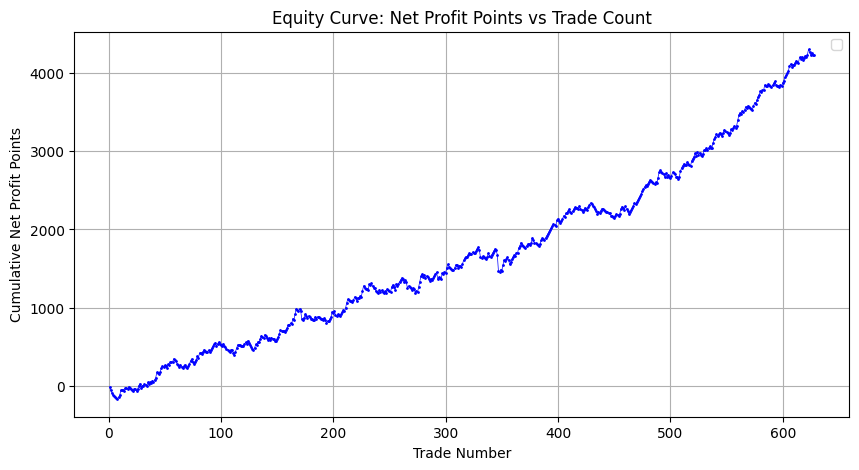

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

def execute_strategy(data, trade_log_file="/content/drive/My Drive/trade_details_5min.csv"):
    """
    Execute both PE and CE strategies on the 1-minute data, log trade details,
    and plot an Equity Curve (Net Profit Points vs Trade Count).

    Args:
        data (pd.DataFrame): The 1-minute DataFrame containing all required data.
        trade_log_file (str): Path to the CSV file where trade details will be logged in Google Drive.

    Returns:
        dict: Summary of backtest results including trade count, win/loss ratio, and net profit.
    """
    # Initialize metrics
    trade_count = 0
    win_count = 0
    loss_count = 0
    net_profit = 0
    win_points = 0
    loss_points = 0
    ce_count = 0
    pe_count = 0

    # List to store trade details
    trade_log = []
    equity_curve = []  # Stores net profit points after each trade

    # Start iterating through rows
    i = 50  # Adjusted for 5-minute strategy
    while i < len(data):
        # Check for PE strategy
        if check_pe(data, i):
            pe_result = execute_pe(data, i)

            # Skip if no trade occurred
            if pe_result['status'] == 'no_trade':
                i += 1  # Move to the next row
                continue

            # Count the trade
            trade_count += 1
            net_profit += pe_result['profit']
            pe_count += 1
            equity_curve.append(net_profit)  # Store equity curve data

            # Determine if it was a win or loss trade
            if pe_result['status'] == 'win':
                win_count += 1
                win_points += pe_result['profit']
            else:
                loss_count += 1
                loss_points += pe_result['profit']

            # Log trade details
            trade_log.append({
                "Trade Type": "PE",
                "Entry Datetime": pe_result['entry_datetime'],
                "Exit Datetime": pe_result['exit_datetime'],
                "Entry Price": pe_result['entry_price'],
                "Exit Price": pe_result['exit_price'],
                "Profit Points": pe_result['profit'],
                "Status": pe_result['status']
            })

            # Skip rows used during this trade
            i += pe_result['rows_used']
            continue

        # Check for CE strategy
        if check_ce(data, i):
            ce_result = execute_ce(data, i)

            # Skip if no trade occurred
            if ce_result['status'] == 'no_trade':
                i += 1  # Move to the next row
                continue

            # Count the trade
            trade_count += 1
            net_profit += ce_result['profit']
            ce_count += 1
            equity_curve.append(net_profit)  # Store equity curve data

            # Determine if it was a win or loss trade
            if ce_result['status'] == 'win':
                win_count += 1
                win_points += ce_result['profit']
            else:
                loss_count += 1
                loss_points += ce_result['profit']

            # Log trade details
            trade_log.append({
                "Trade Type": "CE",
                "Entry Datetime": ce_result['entry_datetime'],
                "Exit Datetime": ce_result['exit_datetime'],
                "Entry Price": ce_result['entry_price'],
                "Exit Price": ce_result['exit_price'],
                "Profit Points": ce_result['profit'],
                "Status": ce_result['status']
            })

            # Skip rows used during this trade
            i += ce_result['rows_used']
            continue

        # If neither strategy triggers a trade, move to the next row
        i += 1

    # Convert trade log to DataFrame and save to Google Drive
    trade_log_df = pd.DataFrame(trade_log)
    trade_log_df.to_csv(trade_log_file, index=False)

    print(f"Trade details saved to Google Drive: {trade_log_file}")

    # Prepare summary results
    results = {
        'Total Trades': trade_count,
        'Winning Trades': win_count,
        'Losing Trades': loss_count,
        'Win Rate (%)': (win_count / trade_count * 100) if trade_count > 0 else 0,
        'Net Profit Points': net_profit,
        'Win Points': win_points,
        'Loss Points': loss_points,
        'PE Trades': pe_count,
        'CE Trades': ce_count
    }

    # Print results
    print("Backtest Results:")
    for key, value in results.items():
        print(f"{key}: {value}")

    # Plot Equity Curve (Net Profit Points vs Trade Count)
    plt.figure(figsize=(10, 5))
    plt.plot(
    range(1, len(equity_curve) + 1),
    equity_curve,
    marker='o', linestyle='-', color='blue',
    markersize=1,  # Smaller marker size for clarity
    linewidth=0.5  # Reduce line width for a thinner curve
    )
    plt.xlabel("Trade Number")
    plt.ylabel("Cumulative Net Profit Points")
    plt.title("Equity Curve: Net Profit Points vs Trade Count")
    plt.legend()
    plt.grid(True)
    plt.show()

    return results


# Example usage
if __name__ == "__main__":
    # Load the data from Google Drive
    file_1min = "/content/drive/My Drive/new_1min_data_2024.csv"  # Updated with new file name
    data = pd.read_csv(file_1min, parse_dates=['date'])
    data.set_index('date', inplace=True)

    # Call the strategy execution
    results = execute_strategy(data)


Remove CE part temporary

Remove PE part temporary